In [38]:
import os
import json
import pickle
import string
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Add, Input, Masking, GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard, CSVLogger

In [39]:
base_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence'
data_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\data'
models_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\models'
pre_processed_data_dir = r'C:\Users\UTKARSH\Desktop\visual intelligence\pre_processed_data'

In [40]:
#Custom Model
def build_model(vocab_size, max_len):
    image_input = Input(shape=(2048,))  # 2048 features from InceptionV3
    image_dense = Dense(256, activation='relu')(image_input)
    # Image feature input

    # Sequence input
    seq_input = Input(shape=(max_len,))
    seq_masking = Masking(mask_value=0)(seq_input)
    seq_embedding = Embedding(vocab_size, 256, mask_zero=False)(seq_masking)
    
    # Stacking three LSTM layers
    lstm_1 = LSTM(256, return_sequences=True, name="lstm_layer_1")(seq_embedding)
    lstm_2 = LSTM(256, return_sequences=True, name="lstm_layer_2")(lstm_1)
    lstm_3 = LSTM(256, name="lstm_layer_3")(lstm_2)

    # Combine the inputs
    combined = Add()([image_dense, lstm_3])
    output = Dense(vocab_size, activation='softmax')(combined)

    model = Model(inputs=[image_input, seq_input], outputs=output)
    model.compile(optimizer='adam', loss='categorical_crossentropy')
    return model

In [41]:
train_captions = os.path.join(pre_processed_data_dir, 'train_captions.txt')
test_captions = os.path.join(pre_processed_data_dir, 'test_captions.txt')
train_img_dir = os.path.join(data_dir, 'train')
test_img_dir = os.path.join(data_dir, 'test')

In [42]:
TOTAL_IMAGES_TRAIN = len(os.listdir(train_img_dir))
TOTAL_IMAGES_TEST = len(os.listdir(test_img_dir))
TOTAL_CAPTIONS_TRAIN = TOTAL_IMAGES_TRAIN * 5
TOTAL_CAPTIONS_TEST = TOTAL_IMAGES_TEST * 5

In [43]:
import image_captioning_utils as icu

In [44]:
# Step 1: Extract image features
extractor = icu.ImageFeatureExtractor()
# train_image_features = extractor.extract_features_for_directory(train_img_dir, limit=1000)
# pickle.dump(train_image_features, open(os.path.join(pre_processed_data_dir, 'train_image_features.pkl'), 'wb'))
train_image_features = pickle.load(open(os.path.join(pre_processed_data_dir, 'train_image_features.pkl'), 'rb'))

# test_image_features = extractor.extract_features_for_directory(test_img_dir, limit=1000)
# pickle.dump(test_image_features, open(os.path.join(pre_processed_data_dir, 'test_image_features.pkl'), 'wb'))
test_image_features = pickle.load(open(os.path.join(pre_processed_data_dir, 'test_image_features.pkl'), 'rb'))

1/1 [==============================] - 0s 31ms/step


In [45]:
# Step 2: Process captions for the selected images
train_image_ids = list(train_image_features.keys())
train_processor = icu.CaptionProcessor(train_captions, train_image_ids)

test_image_ids = list(test_image_features.keys())
test_processor = icu.CaptionProcessor(test_captions, test_image_ids)

VOCAB_SIZE = len(train_processor.tokenizer.word_index) + 1
MAX_LEN = train_processor.max_len

In [46]:
# Step 3: Create sequences for training
X1, X2, y = train_processor.create_sequences(train_image_features, VOCAB_SIZE)

In [47]:
mymodel = build_model(VOCAB_SIZE, MAX_LEN)
mymodel.summary()
# plot_model(mymodel, show_shapes=True)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_9 (InputLayer)           [(None, 43)]         0           []                               
                                                                                                  
 masking_2 (Masking)            (None, 43)           0           ['input_9[0][0]']                
                                                                                                  
 embedding_2 (Embedding)        (None, 43, 256)      879104      ['masking_2[0][0]']              
                                                                                                  
 lstm_layer_1 (LSTM)            (None, 43, 256)      525312      ['embedding_2[0][0]']            
                                                                                            

In [48]:
history = mymodel.fit([X1, X2], y, epochs=30, batch_size=64,validation_split=0.2)

Epoch 1/30
717/717 [==============================] - 28s 34ms/step - loss: 4.9630 - val_loss: 4.4094
Epoch 2/30
717/717 [==============================] - 23s 32ms/step - loss: 3.6634 - val_loss: 4.1534
Epoch 3/30
717/717 [==============================] - 23s 32ms/step - loss: 3.1214 - val_loss: 4.0687
Epoch 4/30
717/717 [==============================] - 23s 32ms/step - loss: 2.7721 - val_loss: 4.0083
Epoch 5/30
717/717 [==============================] - 23s 32ms/step - loss: 2.5032 - val_loss: 4.1023
Epoch 6/30
717/717 [==============================] - 23s 32ms/step - loss: 2.3011 - val_loss: 4.1841
Epoch 7/30
717/717 [==============================] - 23s 32ms/step - loss: 2.1451 - val_loss: 4.2626
Epoch 8/30
717/717 [==============================] - 23s 32ms/step - loss: 2.0180 - val_loss: 4.2923
Epoch 9/30
717/717 [==============================] - 23s 31ms/step - loss: 1.9114 - val_loss: 4.4237
Epoch 10/30
717/717 [==============================] - 23s 32ms/step - loss: 1.825

In [49]:
def plot_history(history):

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(len(loss))

    plt.figure(figsize=(20, 5))
    
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')

    plt.show()

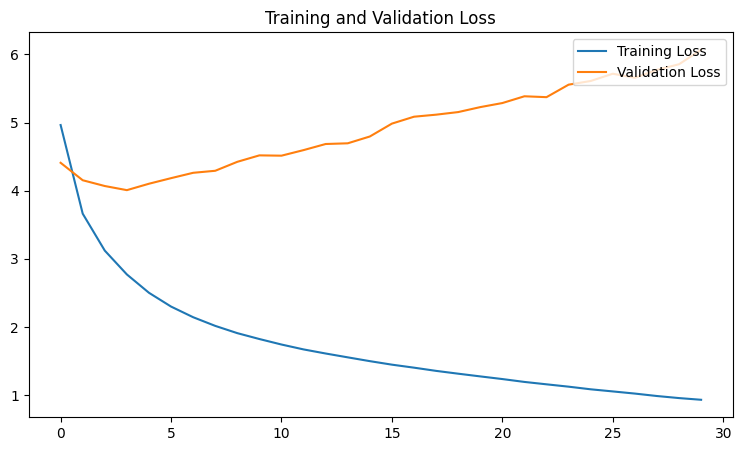

In [50]:
plot_history(history)

In [51]:
mymodel.save(os.path.join(models_dir,'custom_model.h5'))

In [52]:
load_model = load_model(os.path.join(models_dir,'custom_model.h5'))

1/1 [==============================] - 0s 41ms/step
Actual Caption: ----------------------------
startseq A person wearing orange pants standing on a bench endseq
startseq Someone in orange pants stands on a wooden bench endseq
startseq A man standing on a bench with a sign next to them endseq
startseq A person in red pants stands on a wooden bench with a poster endseq
startseq An image of boy standing on top of  a bench endseq
--------------------------------------------
Generated Caption:  startseq a man and a black sitting on person of a flying looking endseq


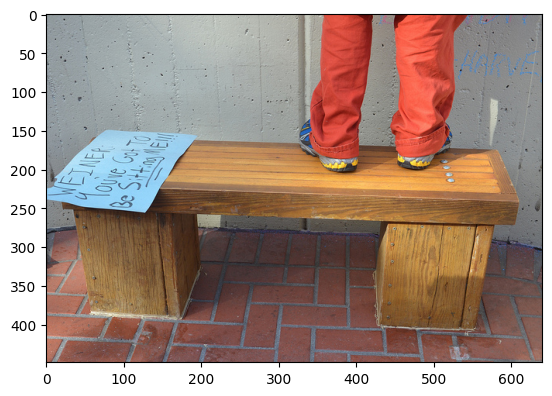

In [53]:
# Step 5: Test caption generation on a new image

model = load_model
random_id = np.random.choice(list(test_processor.captions_dict.keys()))
cap_id = random_id
test_image_path = os.path.join(test_img_dir, cap_id +'.jpg')
test_image_feature = extractor.extract_features(test_image_path)
test_image_feature = np.squeeze(test_image_feature)
generated_caption = icu.generate_caption(model, np.array([test_image_feature]), test_processor.tokenizer, MAX_LEN)

print("Actual Caption: ----------------------------")
for cap in test_processor.captions_dict[cap_id]:
  print(cap)
print("--------------------------------------------")

print("Generated Caption: ", generated_caption)

# Display the image
img = Image.open(test_image_path)
plt.imshow(img)
plt.show()

1/1 [==============================] - 0s 31ms/step
Actual Caption: ----------------------------
startseq A female traveler leaning on a luggage cart endseq
startseq A woman is waiting with a cart full of luggage endseq
startseq A woman next to a cart of luggage at a bus stop endseq
startseq The woman is standing with her luggage endseq
startseq A woman wearing a yellow shirt standing next to luggage endseq
--------------------------------------------
Generated Caption:  startseq a woman standing on luggage in a red shirt terminal endseq


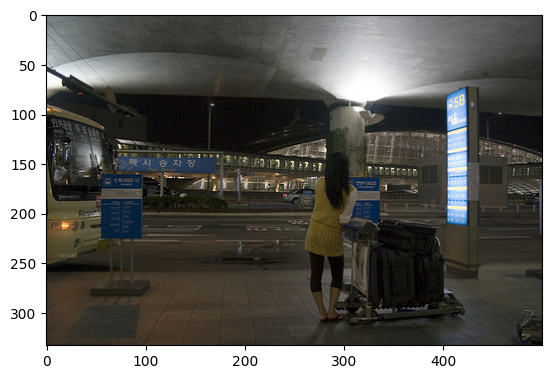

In [54]:
# Step 5: Train caption generation on a new image

model = load_model
random_id = np.random.choice(list(train_processor.captions_dict.keys()))
cap_id = random_id
train_image_path = os.path.join(train_img_dir, cap_id +'.jpg')
train_image_feature = extractor.extract_features(train_image_path)
train_image_feature = np.squeeze(train_image_feature)
generated_caption = icu.generate_caption(model, np.array([train_image_feature]), train_processor.tokenizer, MAX_LEN)

print("Actual Caption: ----------------------------")
for cap in train_processor.captions_dict[cap_id]:
  print(cap)
print("--------------------------------------------")

print("Generated Caption: ", generated_caption)

# Display the image
img = Image.open(train_image_path)
plt.imshow(img)
plt.show()

In [55]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

def calculate_bleu(test_features, test_captions, model, tokenizer, MAX_LEN):
    
    bleu_1_scores = []
    bleu_2_scores = []
    bleu_3_scores = []
    bleu_4_scores = []
    
    for image_id, image_features in test_features.items():
        predicted_caption = icu.generate_caption(model, np.array([image_features]), tokenizer, MAX_LEN)
        predicted_caption = predicted_caption.split()
        
        # Get the list of ground truth captions for this image
        reference_captions = [caption.split() for caption in test_captions[image_id]]
        
        # Smoothing function for higher n-grams
        smooth_fn = SmoothingFunction().method1

        # BLEU-1 (Unigrams)
        bleu_1 = sentence_bleu(reference_captions, predicted_caption, weights=(1, 0, 0, 0), smoothing_function=smooth_fn)
        
        # BLEU-2 (Unigrams + Bigrams)
        bleu_2 = sentence_bleu(reference_captions, predicted_caption, weights=(0.5, 0.5, 0, 0), smoothing_function=smooth_fn)
        
        # BLEU-3 (Unigrams + Bigrams + Trigrams)
        bleu_3 = sentence_bleu(reference_captions, predicted_caption, weights=(0.33, 0.33, 0.33, 0), smoothing_function=smooth_fn)
        
        # BLEU-4 (Unigrams + Bigrams + Trigrams + 4-grams)
        bleu_4 = sentence_bleu(reference_captions, predicted_caption, weights=(0.25, 0.25, 0.25, 0.25), smoothing_function=smooth_fn)

        #Storing BLEU-1,BLEU-2,BLEU-3,BLEU-4
        bleu_1_scores.append(bleu_1)
        bleu_2_scores.append(bleu_2)
        bleu_3_scores.append(bleu_3)
        bleu_4_scores.append(bleu_4)
        
    #Return the average BLEU score across all test images
    return [np.mean(bleu_1_scores),np.mean(bleu_2_scores),np.mean(bleu_3_scores),np.mean(bleu_4_scores)]

In [56]:
bleu_score = calculate_bleu(test_image_features, test_processor.captions_dict, model, test_processor.tokenizer, MAX_LEN)
print(f"Average BLEU-1 Score on Test Dataset: {bleu_score[0]:.4f}")
print(f"Average BLEU-2 Score on Test Dataset: {bleu_score[1]:.4f}")
print(f"Average BLEU-3 Score on Test Dataset: {bleu_score[2]:.4f}")
print(f"Average BLEU-4 Score on Test Dataset: {bleu_score[3]:.4f}")

Average BLEU-1 Score on Test Dataset: 0.4548
Average BLEU-2 Score on Test Dataset: 0.1502
Average BLEU-3 Score on Test Dataset: 0.0629
Average BLEU-4 Score on Test Dataset: 0.0384
